## Introduction
* Part1: Prepare data to visualize the labeled stock price(By sentiment result: delay two days)
* Part2: Realize the LSTM model


## Part1

### Import necessary packages

In [49]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tokenization
import tensorflow as tf
import tensorflow_hub as hub
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from keras.models import Sequential
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout


* Load the combind_sen_stock.csv and Combinded_Delayed_2Days.csv

In [28]:
Twitter_stock1=pd.read_csv("../Data/combind_sen_stock.csv")
Twitter_stock2=pd.read_csv("../Data/Combined_Delayed_2Days.csv")

Twitter_stock2

,Date,Tweets_clean_more,polarity,subjectivity,sentiment,Label_delayed_2Days
0,2013-01-10,to super clear i dont wish could i mandat anyt...,0.216667,0.525000,positive,Decrease
1,2019-01-10,ye get regulatori pushback may avail region go...,0.123333,0.490556,positive,Increase
2,2020-01-10,dome barrel weld made bar pretti good bar need...,0.411111,0.570988,positive,Decrease
3,2012-01-11,the exec conf room tesla use call denali i dec...,0.600000,1.000000,positive,Decrease
4,2016-01-11,sad hear david bowi die he amaz,-0.500000,1.000000,negative,Increase
...,...,...,...,...,...,...
1415,2018-09-07,type peopl world understand binari amp will s...,0.492857,0.567857,positive,Decrease
1416,2014-09-08,excel explan diff betw get orbit v space sugge...,0.250000,0.333333,positive,Decrease
1417,2020-09-08,a la guerr comm à la guerr haha and start twee...,0.100000,0.400000,positive,Decrease
1418,2014-09-09,meet build call just crazi japanes game show ...,-0.400000,0.400000,negative,Increase


* Load the TSLA_labeled.csv dataset

In [29]:
df_lh=pd.read_csv("../Data/TSLA_labeled.csv")
df_lh

,Date,Open,High,Low,Close,Adj Close,Volume,Label
0,2011-12-01,2.171333,2.266000,2.132000,2.173333,2.173333,15453000,Increase
1,2011-12-02,2.188667,2.246000,2.160000,2.220000,2.220000,12042000,Increase
2,2011-12-05,2.235333,2.333333,2.228667,2.294667,2.294667,17401500,Increase
3,2011-12-06,2.280000,2.332000,2.268667,2.324667,2.324667,14277000,Increase
4,2011-12-07,2.308667,2.326000,2.253333,2.279333,2.279333,10114500,Decrease
...,...,...,...,...,...,...,...,...
2353,2021-04-12,228.566666,234.933334,227.363327,233.993332,233.993332,87407100,Increase
2354,2021-04-13,237.566666,254.333328,236.886673,254.106674,254.106674,133958400,Increase
2355,2021-04-14,256.899994,260.263336,242.676666,244.076660,244.076660,147052200,Decrease
2356,2021-04-15,247.699997,247.896667,240.436661,246.283340,246.283340,83546700,Decrease


* Merge Twitter_stock2 with df_lh dataframe

In [30]:
twitter_stock_2=Twitter_stock2.merge(df_lh)
twitter_stock_2.head()


,Date,Tweets_clean_more,polarity,subjectivity,sentiment,Label_delayed_2Days,Open,High,Low,Close,Adj Close,Volume,Label
0,2013-01-10,to super clear i dont wish could i mandat anyt...,0.216667,0.525000,positive,Decrease,2.258000,2.266000,2.225333,2.235333,2.235333,13837500,Decrease
1,2019-01-10,ye get regulatori pushback may avail region go...,0.123333,0.490556,positive,Increase,22.293333,23.025999,22.119333,22.997999,22.997999,90846000,Increase
2,2020-01-10,dome barrel weld made bar pretti good bar need...,0.411111,0.570988,positive,Decrease,32.119331,32.329334,31.580000,31.876667,31.876667,194392500,Decrease
3,2012-01-11,the exec conf room tesla use call denali i dec...,0.600000,1.000000,positive,Decrease,1.841333,1.892000,1.820000,1.882000,1.882000,10084500,Increase
4,2016-01-11,sad hear david bowi die he amaz,-0.500000,1.000000,negative,Increase,14.267333,14.296667,13.533333,13.856667,13.856667,61371000,Decrease


* Create a new column named half_H_L
* The half_H_L equal 1/2*(high-low)

In [31]:
label_line2=np.array(twitter_stock_2["High"])-np.array(twitter_stock_2["Low"])/2
twitter_stock_2[" half_H_L"]=label_line2
twitter_stock_2.head()

,Date,Tweets_clean_more,polarity,subjectivity,sentiment,Label_delayed_2Days,Open,High,Low,Close,Adj Close,Volume,Label,half_H_L
0,2013-01-10,to super clear i dont wish could i mandat anyt...,0.216667,0.525000,positive,Decrease,2.258000,2.266000,2.225333,2.235333,2.235333,13837500,Decrease,1.153334
1,2019-01-10,ye get regulatori pushback may avail region go...,0.123333,0.490556,positive,Increase,22.293333,23.025999,22.119333,22.997999,22.997999,90846000,Increase,11.966332
2,2020-01-10,dome barrel weld made bar pretti good bar need...,0.411111,0.570988,positive,Decrease,32.119331,32.329334,31.580000,31.876667,31.876667,194392500,Decrease,16.539334
3,2012-01-11,the exec conf room tesla use call denali i dec...,0.600000,1.000000,positive,Decrease,1.841333,1.892000,1.820000,1.882000,1.882000,10084500,Increase,0.982000
4,2016-01-11,sad hear david bowi die he amaz,-0.500000,1.000000,negative,Increase,14.267333,14.296667,13.533333,13.856667,13.856667,61371000,Decrease,7.530001


* Save final dataset as Twitter_stock_delay2.csv

In [32]:
twitter_stock_2.to_csv("../Data/Twitter_stock_delay2.csv")

## Part2

### LSTM MODEL

In [51]:
df=pd.DataFrame([Twitter_stock1["Tweets_clean_more"],Twitter_stock2["Label_delayed_2Days"]]).T



In [52]:
df

,Tweets_clean_more,Label_delayed_2Days
0,i made volum model s go now i need work miniat...,Decrease
1,yeah realli mom attest not sure i handl char m...,Increase
2,model s option perform red black i deliv car j...,Decrease
3,if ever want know real truth moon land best on...,Decrease
4,cool person essay it realli reson i felt way c...,Increase
...,...,...
1417,it remov simul improv render resolut congrat ...,Decrease
1418,tesla build collis repair capabl help address ...,Increase
1419,th raptor engin come soon mayb use get that ve...,Decrease
1420,one mani reason need make life multiplanetari ...,NaN


In [34]:
Twitter_stock2["Year"]=[Twitter_stock2["Date"][i][0:4] for i in range(Twitter_stock2.shape[0])]
Twitter_stock2.head()


,Date,Tweets_clean_more,polarity,subjectivity,sentiment,Label_delayed_2Days,Year
0,2013-01-10,to super clear i dont wish could i mandat anyt...,0.216667,0.525000,positive,Decrease,2013
1,2019-01-10,ye get regulatori pushback may avail region go...,0.123333,0.490556,positive,Increase,2019
2,2020-01-10,dome barrel weld made bar pretti good bar need...,0.411111,0.570988,positive,Decrease,2020
3,2012-01-11,the exec conf room tesla use call denali i dec...,0.600000,1.000000,positive,Decrease,2012
4,2016-01-11,sad hear david bowi die he amaz,-0.500000,1.000000,negative,Increase,2016


In [35]:
Twitter_stock2.groupby(["Year"]).max()

,Date,Tweets_clean_more,polarity,subjectivity,sentiment,Label_delayed_2Days
Year,,,,,,
2011,2011-12-30,yeah realli mom attest not sure i handl char m...,0.6,0.708687,positive,No Change
2012,2012-12-26,ye unveil fulli function advanc prototyp model...,0.8,1.000000,positive,No Change
2013,2013-12-26,ye upper stage vent liquid oxygen creat fast m...,1.0,1.000000,positive,Increase
2014,2014-12-31,yeah that worth read what could possibl go wro...,0.9,1.000000,positive,Increase
2015,2015-12-22,yesterday mission space station light cloudi n...,1.0,1.000000,positive,No Change
2016,2016-12-30,yup ye ye pretti close area ratio vacuum mar a...,1.0,1.000000,positive,No Change
2017,2017-12-27,yeah sorri i miss thi would work kwh pack soft...,1.0,1.000000,positive,No Change
2018,2018-12-31,your cruel taunt cut deep deep but i love oh g...,0.8,0.900000,positive,No Change
2019,2019-12-31,you welcom glad help,0.9,1.000000,positive,No Change


### Get the training and testing dataset

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df["Tweets_clean_more"], df["Label_delayed_2Days"], test_size=0.2)

print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('y_train shape: ', y_train.shape)
print('y_val shape: ', y_val.shape)

X_train shape:  (1137,)
X_val shape:  (285,)
y_train shape:  (1137,)
y_val shape:  (285,)


  ### the proportion of trainin and validation dataset

In [54]:
print('Train Class Proportion:\n', y_train.value_counts() / len(y_train) * 100)
print('\nValidation Class Proportion:\n', y_val.value_counts() / len(y_val) * 100)

Train Class Proportion:
 Increase     49.516271
Decrease     47.757256
No Change     2.550572
Name: Label_delayed_2Days, dtype: float64

Validation Class Proportion:
 Decrease     52.280702
Increase     43.508772
No Change     4.210526
Name: Label_delayed_2Days, dtype: float64


### Tokenize the tweets
* Get the xtrain and xtest 

In [39]:


tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df["Tweets_clean_more"])
xtrain= tokenizer.texts_to_sequences(X_train)
xtest= tokenizer.texts_to_sequences(X_val) 




* Set the maxlen=50. In order to keep the vector same length.
* Then pad xtrain and xtest to X_train_text and X_val_text.
* Check the shape of X_train_text,X_val_text.

In [40]:
vocab_size=len(tokenizer.word_index)+1


 
maxlen = 50

X_train_text = pad_sequences(xtrain, padding='post', maxlen=maxlen)
X_val_text = pad_sequences(xtest, padding='post', maxlen=maxlen)

print('X_train shape:', X_train_text.shape)
print('X_train shape:', X_val_text.shape)



X_train shape: (1137, 50)
X_train shape: (285, 50)


* Training our LSTM model

In [41]:
embedding_dim=50
model=Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
         output_dim=embedding_dim,
         input_length=maxlen))
model.add(layers.LSTM(units=50,return_sequences=True))
model.add(layers.LSTM(units=10))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", 
     metrics=['accuracy'])
model.summary()
model.fit(X_train_text,y_train, epochs=20, batch_size=16, verbose=False)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 50)            368000    
                                                                 
 lstm_4 (LSTM)               (None, 50, 50)            20200     
                                                                 
 lstm_5 (LSTM)               (None, 10)                2440      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 6)                 66        
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 390,713
Trainable params: 390,713
Non-tr

In [109]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df["Tweets_clean_more"])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 7359 unique tokens.


* Truncate and pad the input sequences so that they are all in the same length for modeling.

In [110]:
X = tokenizer.texts_to_sequences(df["Tweets_clean_more"])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1422, 250)


* Converting categorical labels to numbers.

In [111]:
Y = pd.get_dummies(df["Label_delayed_2Days"]).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1422, 3)


* Train test split.

In [112]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1066, 250) (1066, 3)
(356, 250) (356, 3)


In [113]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(50, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 6
batch_size = 45

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/6
22/22 [==============================] - 8s 209ms/step - loss: 0.9811 - accuracy: 0.4818 - val_loss: 0.8793 - val_accuracy: 0.4486
Epoch 2/6
22/22 [==============================] - 4s 185ms/step - loss: 0.7979 - accuracy: 0.5016 - val_loss: 0.8553 - val_accuracy: 0.5047
Epoch 3/6
22/22 [==============================] - 4s 185ms/step - loss: 0.7721 - accuracy: 0.6392 - val_loss: 0.8599 - val_accuracy: 0.4766
Epoch 4/6
22/22 [==============================] - 4s 185ms/step - loss: 0.7046 - accuracy: 0.8050 - val_loss: 0.9114 - val_accuracy: 0.4393
Epoch 5/6
22/22 [==============================] - 4s 194ms/step - loss: 0.5099 - accuracy: 0.8634 - val_loss: 1.1395 - val_accuracy: 0.4299


In [114]:
accr = model.evaluate(X_test,Y_test)
accr

12/12 [==============================] - 0s 27ms/step - loss: 0.9896 - accuracy: 0.5056


[0.9895976185798645, 0.5056179761886597]

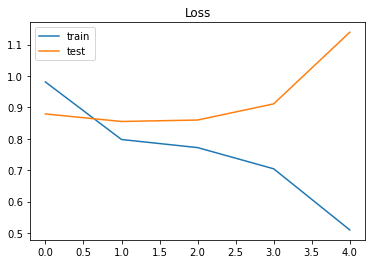

In [115]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

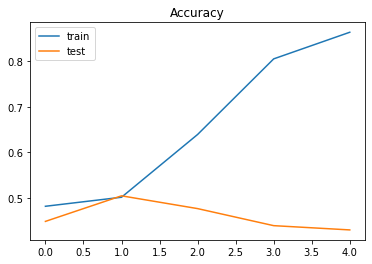

In [116]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

Results:
The LSTM model show us that the predict result. 

